## Introduction

This notebook introduces the Python code used to implement some of the concepts presented in the first set of lectures covering text analysis methods and their applications to social sciences. 

The code below relies on several packages, including the standard numpy and pandas ones. In case you need a refresher on how to install packages or update them, please check the Python installation [instructions](https://www.dropbox.com/s/lcx37uazu9i5vua/Python%20Setup%20Instructions.pdf?dl=0). Alternatively, do not hesitate in exploring the depths of [Stack Overflow](https://stackoverflow.com/), which likely contain answers to all questions you may pose today.

The data used below consists of different datasets used to highlight different aspects of the methods shown today. The first one deals with court case transcripts in the US involving the death penalty, and will be used to showcase pre-processing techniques. The second database includes raw text data on the Bank of England Monetary Policy Committee transcripts between 1997 and 2014, and will be used to test your understanding of the core techniques.

__Note__: In case you needed a Python crash course, you can explore [this](https://www.dropbox.com/s/b4jxmv1pe3tmz3v/Python_Brushup.ipynb?dl=0) jupyter notebook first.

In [1]:
import os
import zipfile as zip
import pandas as pd
import csv
import numpy as np

from scipy.sparse import find, csr_matrix
from scipy import stats


import re
from collections import Counter
from pprint import pprint
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import string

#Sklearn
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.parsing.porter import PorterStemmer

# nltk
import nltk
from nltk.stem import SnowballStemmer
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Change your main directory accordingly
maindir = 'E:/Dropbox/_Pre-Doc/NLP_Class_Preparation/David/python_prac1'
data = maindir + '/data'

### Introduction - Death Penalty Court Cases

In [2]:
df = pd.read_csv(data +'/death-penalty-cases.csv')

df.head() # Show the top few lines of data
# df.info() # Show information about the dataframe

,court_id,author_id,state,year,dateFiled,citeCount,snippet
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti..."
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...


array([[<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'citeCount'}>]], dtype=object)

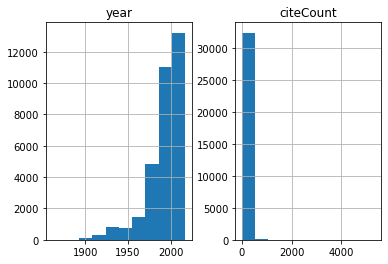

In [3]:
df[['year','citeCount']].hist() # Visualize court citations per year

<br>
A first look at the data shows that our csv consists of US court cases with metadata on the court ID, the authority ID, the State in which the court was located, datetime information and a snippet containing a description of the case.

Let us now look at the snippet of the first court case listed in our database.

In [4]:
first = str(df['snippet'][0])
print(first) # Explore the text in our first document

N.J.   ( )
  A. d  
IN RE WAIVER OF DEATH PENALTY.
The Supreme Court of New Jersey.
September & ; and County Court Judges

Re: Waiver of the Death Penalty
*  The Supreme Court is concerned by the excessive& ;cases where the prosecutor is not seeking the death penalty. It is cognizant of the fact that this situation& ;Although the prosecutor had a right to waive the death penalty and so inform the jury, the jury nevertheless& ;would assume, as did the prosecutor, that the death penalty would not be returned as it was not asked for


### Text Pre-processing

In class we saw how uninformative data may add noise and prove computationally costly. In the example above, one can argue not all raw character strings are equally relevant for analysis, or that non-alphabetic elements may add little information but increase the feature space. 

Let us explore the different steps one __can__ use to reduce the number of features and make a program more computational-friendly.

In [5]:
# Tokenize
tokens = first.split()
print(tokens)

['N.J.', '(', ')', 'A.', 'd', 'IN', 'RE', 'WAIVER', 'OF', 'DEATH', 'PENALTY.', 'The', 'Supreme', 'Court', 'of', 'New', 'Jersey.', 'September', '&', ';', 'and', 'County', 'Court', 'Judges', 'Re:', 'Waiver', 'of', 'the', 'Death', 'Penalty', '*', 'The', 'Supreme', 'Court', 'is', 'concerned', 'by', 'the', 'excessive&', ';cases', 'where', 'the', 'prosecutor', 'is', 'not', 'seeking', 'the', 'death', 'penalty.', 'It', 'is', 'cognizant', 'of', 'the', 'fact', 'that', 'this', 'situation&', ';Although', 'the', 'prosecutor', 'had', 'a', 'right', 'to', 'waive', 'the', 'death', 'penalty', 'and', 'so', 'inform', 'the', 'jury,', 'the', 'jury', 'nevertheless&', ';would', 'assume,', 'as', 'did', 'the', 'prosecutor,', 'that', 'the', 'death', 'penalty', 'would', 'not', 'be', 'returned', 'as', 'it', 'was', 'not', 'asked', 'for']


<br>
Tokenizing represents the most basic step in creating documents from raw data. Note however that simply separating all pieces adds considerable noise. As an example, we may not be interested in including '(, )' as later on this will add an additional dimension to our document-term matrix which will increase the dimensionality of our problem while adding little information. Similarly, items like ';cases' will be considered as a different item to 'cases'. Finally, 'PENALTY' and 'penalty' will be treated as different terms. In order to control for these, we will remove non-alphabetic elements, punctuation and convert our data to lower case.

In [6]:
first = first.lower() # Replace all upper cases for lower cases

first = first.strip() # Remove any trailing or leading spaces from words

first.translate(str.maketrans('', '', string.punctuation)) # Remove punctuations

first = [x for x in first.split() if not any(c.isdigit() for c in x)] #Remove any numbers
first = ' '.join(first)

result='' 
for item in gensim.utils.simple_preprocess(first, min_len = 2, max_len = 30): # Remove items that may be too large or small
    result = result + ' ' + item
    result = result.strip() #Strip whitespace out       
print(result)

in re waiver of death penalty the supreme court of new jersey september and county court judges re waiver of the death penalty the supreme court is concerned by the excessive cases where the prosecutor is not seeking the death penalty it is cognizant of the fact that this situation although the prosecutor had right to waive the death penalty and so inform the jury the jury nevertheless would assume as did the prosecutor that the death penalty would not be returned as it was not asked for


<br>
Note that above we called GENSIM's simple_preprocess() utility in order to tokenize our cleansed data. This utility is a convenient tool used frequently in text analysis as it lowercases, tokenizes, de-accents and removes non-alphabetic elements. The resulting text is printed above as a reduced set of unicode terms.

There is more one may do, however. Consider the word _'the'_ or _'it'_. These are arguably very present in most texts but provide little information (cf. Zipf's law) that may be used in later analysis. It stands to reason then that the next step shoulf be to eliminate very common words used as connectors, which take up memory but add little in terms of information. We define these words as stopwrods.

In [7]:
#Create a list of stopwords: combine the GENSIM and NLTK stopwords

#Gensim
gensim_sws = gensim.parsing.preprocessing.STOPWORDS
print(len(gensim_sws))

gensim_sws_list = list(gensim_sws)
print('GENSIM stopwords:',len(gensim_sws_list))

#NLTK
nltk_stop_words = stopwords.words('english') #Load the list of English stopwords from NLTK
print('NLTK stopwords:',len(nltk_stop_words))

stop_words = list(set(gensim_sws_list + nltk_stop_words)) #Concatenate the two stop word lists
print('Total stopwords:',len(stop_words))

337
GENSIM stopwords: 337
NLTK stopwords: 179
Total stopwords: 390


In [8]:
# Remove stopwords
result=''
for token in gensim.utils.simple_preprocess(first, min_len = 2, max_len = 30):
    if token not in stop_words: # Only pass tokens which are not in our list of stopwords
        result = result + ' ' + token
        result = result.strip() #Strip whitespace out       
print(result)

waiver death penalty supreme court new jersey september county court judges waiver death penalty supreme court concerned excessive cases prosecutor seeking death penalty cognizant fact situation prosecutor right waive death penalty inform jury jury assume prosecutor death penalty returned asked


<br>It seems reasonable to assume that the terms printed above are more tractable now, and will help allay dimensionality concerns. Let's transform the list of tokens in a count vector of unigrams.

In [9]:
result_list=[]
for token in gensim.utils.simple_preprocess(first, min_len = 2, max_len = 30) :
    if token not in stop_words : #and len(token) > 3 can be added to get rid of tokens that are smalller than 3 characters
        result_list.append(token) # Create a list of tokens
print(result_list)

['waiver', 'death', 'penalty', 'supreme', 'court', 'new', 'jersey', 'september', 'county', 'court', 'judges', 'waiver', 'death', 'penalty', 'supreme', 'court', 'concerned', 'excessive', 'cases', 'prosecutor', 'seeking', 'death', 'penalty', 'cognizant', 'fact', 'situation', 'prosecutor', 'right', 'waive', 'death', 'penalty', 'inform', 'jury', 'jury', 'assume', 'prosecutor', 'death', 'penalty', 'returned', 'asked']


In [10]:
freqs = Counter(result_list) # Bag of Words representation for the first court case
freqs.most_common()[:10]

[('death', 5),
 ('penalty', 5),
 ('court', 3),
 ('prosecutor', 3),
 ('waiver', 2),
 ('supreme', 2),
 ('jury', 2),
 ('new', 1),
 ('jersey', 1),
 ('september', 1)]

<br>We may also be interested in further reducing dimensionality by reducing words to their common linguistic root. In order to do so, we can either _stem_ or _lemmatize_ words. Stemming is a relatively crude method for cataloging related words; it essentially removes letters from the end until the stem is reached.

In [11]:
stemmer = SnowballStemmer('english') # Stemming words using NLTK utility SnowballStemmer, or Porter2
tokens_stemmed = [stemmer.stem(t) for t in freqs]
print(tokens_stemmed)

['waiver', 'death', 'penalti', 'suprem', 'court', 'new', 'jersey', 'septemb', 'counti', 'judg', 'concern', 'excess', 'case', 'prosecutor', 'seek', 'cogniz', 'fact', 'situat', 'right', 'waiv', 'inform', 'juri', 'assum', 'return', 'ask']


<br>Unfortunately, English has many exceptions where a more sophisticated method is required. In contrast to stemming, lemmatization looks beyond word reduction and considers a language's full vocabulary to apply a morphological analysis to words. The lemma of _'was'_ is _'be'_ and the lemma of _'mice'_ is _'mouse'_.

In [12]:
import spacy # spaCy is a powerful library but an introduction is beyond the scope of this notebook.
nlp = spacy.load('en_core_web_sm')

def show_lemmas(text): # Facilitate readability of lemmas
    for token in text:
        print(f'{token.text:{12}} {token.pos_:{6}} {token.lemma:<{22}} {token.lemma_}')
        
freqs = nlp(result + ' mice and mouse') # Add discretionary word to show the strengths of lemmatizing documents
show_lemmas(freqs)

waiver       PROPN  2444333469187363208    waiver
death        PROPN  17835866735480682125   death
penalty      PROPN  17484722512493506432   penalty
supreme      PROPN  4767139463274071201    supreme
court        PROPN  9597162758872268865    court
new          PROPN  4753564829687343602    new
jersey       PROPN  4620547567241878919    jersey
september    PROPN  7261505081402976146    september
county       PROPN  9750629117708145069    county
court        NOUN   9597162758872268865    court
judges       NOUN   13878232464834663324   judge
waiver       PROPN  2444333469187363208    waiver
death        NOUN   17835866735480682125   death
penalty      NOUN   17484722512493506432   penalty
supreme      PROPN  4767139463274071201    supreme
court        PROPN  9597162758872268865    court
concerned    VERB   16371372851814722007   concern
excessive    ADJ    10025728121779276943   excessive
cases        NOUN   8110129090154140942    case
prosecutor   NOUN   6366927874882496819    prosecu

<br>The code above can be easily scaled to all documents in the corpus, as shown below

In [13]:
#Define pre-processing functions
import string
table = str.maketrans('', '', string.punctuation)

def remove_punctuation(s):
    return s.translate(table)

def remove_words_with_numbers(text):
    result = [x for x in text.split() if not any(c.isdigit() for c in x)]
    res_text = ' '.join(result)
    return res_text

def clean_str(text):
    result=''
    text = remove_punctuation(text)
    res_text = remove_words_with_numbers(text)
    for token in gensim.utils.simple_preprocess(res_text, min_len = 2, max_len = 30) :
        if token not in stop_words: 
            result = result + ' ' + token
            result = result.strip() #Strip whitespace out       
    return result

def clean_list(text):
    result = []
    text = remove_punctuation(text)
    res_text = remove_words_with_numbers(text)
    for token in gensim.utils.simple_preprocess(res_text, min_len = 2, max_len = 30) :
        if token not in stop_words : #and len(token) > 3 can be added to get rid of tokens that are smalller than 3 characters
            result.append(token)   
    return result

In [14]:
#Apply preprocessing function
df['snippet'] = df['snippet'].apply(lambda x: clean_str(x))
df['snippet_list'] = df['snippet'].apply(lambda x: clean_list(x))

df.head()

,court_id,author_id,state,year,dateFiled,citeCount,snippet,snippet_list
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,nj waiver death penalty supreme court new jers...,"[nj, waiver, death, penalty, supreme, court, n..."
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,death penalty se unconstitutional discretionar...,"[death, penalty, se, unconstitutional, discret..."
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,contention assessment death penalty article su...,"[contention, assessment, death, penalty, artic..."
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,nmsc matter death penalty sentencing jury inst...,"[nmsc, matter, death, penalty, sentencing, jur..."
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume district attorney orally waived death p...,"[assume, district, attorney, orally, waived, d..."


In [15]:
full_text=np.hstack(df['snippet_list']) # Measure word frequency across the entire corpus
full_freqs = Counter(full_text)
full_freqs.most_common()[:20]

[('death', 91343),
 ('penalty', 89775),
 ('court', 11202),
 ('state', 9509),
 ('case', 9122),
 ('defendant', 8213),
 ('jury', 7657),
 ('trial', 7266),
 ('imposition', 6573),
 ('imposed', 6225),
 ('cases', 6190),
 ('murder', 5402),
 ('seek', 4487),
 ('statute', 4425),
 ('act', 4087),
 ('impose', 3766),
 ('effective', 3682),
 ('antiterrorism', 3279),
 ('life', 3278),
 ('appellant', 3104)]

<br>For a nice visualization of our selected features, we can construct a word cloud

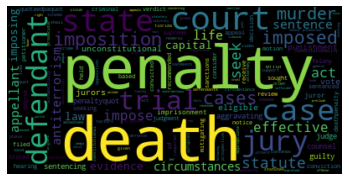

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate_from_frequencies(full_freqs)

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

<br>Note that some words are extremely pervalent in our texts. In particular, words like _death_ or _penalty_ appear in nearly every document, a non-surprising result considering the nature of our data. In later analysis, one may want to remove these words given the lack of per-document variation. The same applies to words that may be extremely rare across our corpus.

The exercise above serves to ilustrate some of the steps that a researcher may use to reduce the dimensionality and noise in the data. Most of these processes are included and run in the background of most utilities used for text analysis. An example is [Scikit-learn](https://scikit-learn.org/stable/)'s [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), which pre-processes any corpus of raw data into a document-term matrix of token counts.

In [17]:
df1 = pd.read_csv(data + '/death-penalty-cases.csv')

In [18]:
vec = CountVectorizer(max_features=20, # feature number is calibrated to ease comparability with our list above
                        stop_words='english')
X = vec.fit_transform(df1['snippet'])
words = vec.get_feature_names()
print(words)

['act', 'appellant', 'case', 'cases', 'court', 'death', 'defendant', 'effective', 'impose', 'imposed', 'imposition', 'jury', 'life', 'murder', 'penalty', 'quot', 'seek', 'state', 'statute', 'trial']


<br>In the code above, X corresponds to a numpy array of counts for the most prevalent words in our corpus. We can represent this matrix as our document-term matrix. In order to do so, let's first reduce the dimension of features in order to facilitate readability 

In [19]:
vec = CountVectorizer(max_features=4, # feature number is calibrated to ease comparability with our list above
                        stop_words='english')
X = vec.fit_transform(df1['snippet'])
words = vec.get_feature_names()
print(words)

['court', 'death', 'penalty', 'quot']


In [20]:
X = X.todense() # Returns a dense matrix representation of our numpy array
print(X)

[[3 5 5 0]
 [0 9 9 1]
 [0 5 6 0]
 ...
 [0 8 8 0]
 [0 1 1 0]
 [0 3 4 0]]


In [21]:
X = X/X.sum(axis=1) # Relative term frequency, in practice the feature space is much larger
print(X)

[[0.23076923 0.38461538 0.38461538 0.        ]
 [0.         0.47368421 0.47368421 0.05263158]
 [0.         0.45454545 0.54545455 0.        ]
 ...
 [0.         0.5        0.5        0.        ]
 [0.         0.5        0.5        0.        ]
 [0.         0.42857143 0.57142857 0.        ]]


In [22]:
for i, word in enumerate(words):
    column = X[:,i]
    df1['x_'+word] = column

df1.head()

,court_id,author_id,state,year,dateFiled,citeCount,snippet,x_court,x_death,x_penalty,x_quot
0,nj,NaN,NJ,1965,1965-09-14T00:00:00Z,8,N.J. ( )\n A. d \nIN RE WAIVER OF DEATH PE...,0.230769,0.384615,0.384615,0.000000
1,fla,4019.0,FL,1973,1973-07-26T00:00:00Z,552,"whether the death penalty is, per se, unconsti...",0.000000,0.473684,0.473684,0.052632
2,texcrimapp,5765.0,TX,1975,1975-04-16T00:00:00Z,143,# ;s contention that the assessment of the dea...,0.000000,0.454545,0.545455,0.000000
3,nm,NaN,NM,2009,2009-11-30T00:00:00Z,0,. d ( )\n -NMSC- \nIN THE MATTER OF DEATH PE...,0.000000,0.500000,0.500000,0.000000
4,texcrimapp,5758.0,TX,1944,1944-12-20T00:00:00Z,56,assume the district attorney orally waived the...,0.000000,0.428571,0.428571,0.142857


<br>Note that some applications go beyond the use of unigrams to perform text analysis. CountVectorizer can easily adapt counts for terms that may either be unigrams (one word) or several words (bigrams, trigrams).

In [23]:
df1 = pd.read_csv(data + '/death-penalty-cases.csv')
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=20,
                        stop_words='english',
                        ngram_range=(1,3))
X = vec.fit_transform(df1['snippet'])

In [24]:
words = vec.get_feature_names()
print(words[:20])

['act', 'case', 'cases', 'court', 'death penalty imposed', 'defendant', 'imposed', 'imposition', 'imposition death', 'imposition death penalty', 'jury', 'murder', 'penalty imposed', 'quot', 'seek', 'seek death', 'seek death penalty', 'state', 'statute', 'trial']


The weighting implemented above was rather crude; optimally, we would like to transform our counts with __tf-idf__. In order to do so, we make use of Scikit-learn's [TfIdfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), which combines the pre-processing and counting of CountVectorizer with the convenient downscaling of a TF-IDF transformation.

In [25]:
tfidf = TfidfVectorizer(min_df = 0.01,
                        max_df = 0.9,
                        max_features=20,
                        stop_words='english',
                        use_idf=True,
                        ngram_range=(1,3))
X_tfidf = tfidf.fit_transform(df1['snippet'])
names = tfidf.get_feature_names()
print(names)

['act', 'case', 'cases', 'court', 'death penalty imposed', 'defendant', 'imposed', 'imposition', 'imposition death', 'imposition death penalty', 'jury', 'murder', 'penalty imposed', 'quot', 'seek', 'seek death', 'seek death penalty', 'state', 'statute', 'trial']


In [26]:
# Visualize tf-idf weights for the selected features
summarizer_1 = lambda x: np.mean(x,axis=0)
dw = summarizer_1(X_tfidf)
dft = pd.DataFrame(np.reshape(dw,(20,1)), 
                   index=tfidf.get_feature_names(), columns = ["tfidf"])
dft

,tfidf
act,0.070765
case,0.111922
cases,0.082163
court,0.117503
death penalty imposed,0.044744
defendant,0.091001
imposed,0.066964
imposition,0.063218
imposition death,0.060015
imposition death penalty,0.059887


<br> <br> 

### Application - Sentiment Analysis on the Bank of England's MPC meetings

Let's apply some of the techniques learnt above to perform basic sentiment analysis using text from the Bank of England's Monetary Policy Committees as an example. Let's first read the data

In [208]:
# Read txt file
df = pd.read_csv(data + '/BoE_mpc_minutes.txt', encoding="utf-8", sep="\t")

<br>Note that the Pandas DataFrame we build separates columns at '\t'. This corresponds to ASCII Horizontal Tabs. For more string literals, you can check Python's own [reference manual](https://docs.python.org/2.0/ref/strings.html).

In [209]:
# Let's look at some of the first data entries
df.head()

,year,minutes
0,199706,1 Sections I to V of this minute summarise t...
1,199706,The 12-month growth rate of notes and coins ...
2,199706,"Broad money, too, decelerated in April: its ..."
3,199706,Lending growth continued at around 9% in ...
4,199706,Lending to individuals remained robust in...


In [210]:
df.shape #The txt file contains 7,277 rows, each corresponding to a YYYYMM date identifier and a paragraph

(7277, 2)

<br>
In order to provide a more intuitive interpretation of the document word counts, we will aggregate rows at the MPC meeting level.

In [211]:
df = df.groupby('year').agg(lambda p: ' '.join(p))

In [212]:
df.shape

(209, 1)

In [213]:
df.minutes.values[0][:2000]

'  1 Sections I to V of this minute summarise the analysis presented to the MPC by Bank staff and the BankÃ\x95s regional agents, and incorporate also information that became available to the Committee after the presentation but prior to the 6 June meeting.     Monetary conditions   The 12-month growth rate of notes and coins had fallen back since January, when it was 7.1%. It had fallen to 6.3% in April and the provisional estimate for May was 6.1%. It was not yet clear whether the fall simply reflected a deceleration in demand for cash following the recent fall in retail price inflation, or whether it had implications for future spending.   Broad money, too, decelerated in April: its 12-month growth rate fell back to 10.2%, having been above 11% in February and March. M4 went up by 0.2% in April: retail M4 fell and wholesale M4 decelerated, perhaps partly because the monthÃ\x95s public finances were stronger than expected. IndividualsÃ\x95 M4 holdings had accelerated modestly this ye

In [214]:
# We can make CountVectorizer ignore digits by passing a pre-processor
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) # This uses regular expressions, an alternative and flexible method to the one we used above
    return text

# Initiate CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.95,  
                        max_features=10000,
                        stop_words='english',
                        preprocessor=preprocess_text,
                        # ngram_range=(1,3) # Exercise: Try the same analysis using n-grams
                     )

# Pass raw data to vec
X_mat = vec.fit_transform(df['minutes'])

In [215]:
words = vec.get_feature_names()
print(words[:20])

['abate', 'abated', 'abating', 'ability', 'able', 'abnormal', 'abnormally', 'abolition', 'abour', 'abroad', 'abrupt', 'abruptly', 'abs', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbing']


In [216]:
# Check dimensions of our data - This is below CountVectorizer maximum, which indicates we've exhausted the dataframe
print('Term count:',len(words))

Term count: 4914


<br>Some of the words are similar to eachother, and chances are they share a common root. We can pass a callable as analyzer to the CountVectorizer constructor to provide a custom analyzer. The aim of repeating the CountVectorizer is to show the flexibility with which the constructor can produce tractable data.

In [217]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
analyzer = CountVectorizer().build_analyzer()

# We can make CountVectorizer ignore digits and stem words by passing an analyzer
def stemmed_words(text):
    text = text.lower() # Replace upper cases
    text = re.sub(r'\d+', '', text) # This uses regular expressions, an alternative and flexible method to the one we used above
    return (stemmer.stem(w) for w in analyzer(text)) # Stems the words at the document level

# Initiate CountVectorizer
vec = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.95,  
                        max_features=10000,
                        stop_words='english',
                        analyzer=stemmed_words,
                        # ngram_range=(1,3) # Exercise: Try the same analysis using n-grams
                     )

# Pass raw data to vec
X_mat = vec.fit_transform(df['minutes'])

In [218]:
words = vec.get_feature_names()
print(words[:20])

['ab', 'abandon', 'abat', 'abil', 'abl', 'abnorm', 'abolit', 'abour', 'abroad', 'abrupt', 'absenc', 'absent', 'absolut', 'absorb', 'absorpt', 'abstract', 'academ', 'acceler', 'accentu', 'accept']


In [219]:
# Check dimensions of our data again - Note the sizeable reduction in terms, suggesting many did indeed share a root
print('Term count:',len(words))

Term count: 3279


In [220]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfconverter = TfidfTransformer()
X_mat = tfidfconverter.fit_transform(X_mat).todense()

In [221]:
print(X_mat)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01696307 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.02129455 0.04730877 0.        ]
 [0.         0.         0.         ... 0.06896463 0.03830361 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [222]:
# Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/)
lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly'],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners',
                       'winning', 'worthy']}


In [223]:
# Let's stemm these words as well, so as to match sentiment words with our pre-processed data
X_mat.shape

(209, 3279)

In [224]:
newdf = pd.DataFrame(X_mat)
newdf.columns = vec.get_feature_names()

In [225]:
newdf.head()

,ab,abandon,abat,abil,abl,abnorm,abolit,abour,abroad,abrupt,...,yk,yougov,young,younger,zero,zew,zone,â¼,â½,â¾
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,0.0,0.0,0.000000,0.000000,0.012638,0.0,0.051682,0.000000,0.013724,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,0.0,0.0,0.016963,0.013097,0.011006,0.0,0.000000,0.000000,0.011951,0.000000,...,0.0,0.0,0.0,0.0,0.011303,0.0,0.0,0.00000,0.000000,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.017316,0.034163,0.015052,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,0.0,0.0,0.000000,0.000000,0.023017,0.0,0.000000,0.000000,0.012497,0.000000,...,0.0,0.0,0.0,0.0,0.023638,0.0,0.0,0.09402,0.060923,0.0


In [226]:
def positive(row):
    return row[column] * 1

def negative(row):
    return row[column] * -1

for column in newdf:
    if column in lmdict['Negative']:
        newdf[column] = newdf.apply(lambda row: negative(row),axis=1)
    elif column in lmdict['Positive']:
        newdf[column] = newdf.apply(lambda row: positive(row),axis=1)

In [227]:
newdf.head()

,ab,abandon,abat,abil,abl,abnorm,abolit,abour,abroad,abrupt,...,yk,yougov,young,younger,zero,zew,zone,â¼,â½,â¾
0,0.0,-0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
1,0.0,-0.0,0.000000,0.000000,0.012638,0.0,0.051682,0.000000,0.013724,-0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
2,0.0,-0.0,0.016963,0.013097,0.011006,0.0,0.000000,0.000000,0.011951,-0.000000,...,0.0,0.0,0.0,0.0,0.011303,0.0,0.0,0.00000,0.000000,0.0
3,0.0,-0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.017316,0.034163,-0.015052,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0
4,0.0,-0.0,0.000000,0.000000,0.023017,0.0,0.000000,0.000000,0.012497,-0.000000,...,0.0,0.0,0.0,0.0,0.023638,0.0,0.0,0.09402,0.060923,0.0


In [228]:
newdf['Sentiment'] = (newdf.where(newdf > 0).sum(1)-newdf.where(newdf < 0).sum(1))/(newdf.where(newdf > 0).sum(1)+newdf.where(newdf < 0).sum(1)) -1

In [229]:
newdf['Sentiment'][:20]

0     0.045324
1     0.053075
2     0.039778
3     0.050498
4     0.046366
5     0.071389
6     0.075173
7     0.070309
8     0.084816
9     0.072353
10    0.072370
11    0.067517
12    0.054863
13    0.089516
14    0.097005
15    0.114102
16    0.102107
17    0.124615
18    0.100221
19    0.077347
Name: Sentiment, dtype: float64

### Exercises

1. Join the sentiment index to our original dataframe

2. Use quarterly GDP data for the UK for the same period in order to study the correlation between our sentiment index and the UK's economic performance.

In [231]:
gdp_df = pd.read_csv(data + '/uk_quarterly_gdp.csv')

# misc = df.groupby('quarter').agg(np.mean)

# Use misc.corr() to draw correlations

3. Plot the evolution across time of GDP and the index of sentiment. Try fine tuning the dictionary (mainly, stemming words) to better adjust it.